In [ ]:
!pip install keras==2.15.0

In [1]:
import keras
print("Keras version:", keras.__version__)

2024-04-19 01:36:15.057081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 01:36:15.057207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 01:36:15.193045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Keras version: 2.15.0


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate, Flatten, Dense, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import activations
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Conv2D, Input, Flatten, Dense, BatchNormalization, LeakyReLU, \
    MaxPooling2D, Dropout, Concatenate, Activation
import random
import numpy as np
from keras.datasets import cifar10
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
import keras
from sklearn.metrics import classification_report

In [3]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [4]:
SIZE = (128, 128)

folder_aircrafts_path = '/kaggle/input/rfaircrafts/olehratinskiy_diploma_dataset/'

types = ['attack_helicopters', 'fighter_aircrafts', 'il-76', 'tu-22', 'tu-95', 'tu-160', 'noaircrafts']

img_list = []
labels = []

for idx, aircraft_type in enumerate(types):
    for filename in sorted(os.listdir(folder_aircrafts_path + aircraft_type + '/')):
        img_path = os.path.join(folder_aircrafts_path + aircraft_type + '/', filename)
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, SIZE)
        img_list.append(img_resized)
        labels.append(idx)

X = np.array(img_list)
labels = np.array(labels)

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    dtype='uint8'
)

updated_images = []
updated_labels = []

for img, label in zip(X_train, y_train):
    img = img.reshape((1,) + img.shape)
    for _ in range(30):
        new_img = datagen.flow(img, batch_size=1)[0][0]
        updated_images.append(new_img)
        updated_labels.append(label)

X_train = np.array(updated_images)
y_train = np.array(updated_labels)


updated_images = []
updated_labels = []

for img, label in zip(X_test, y_test):
    img = img.reshape((1,) + img.shape)
    for _ in range(30):
        new_img = datagen.flow(img, batch_size=1)[0][0]
        updated_images.append(new_img)
        updated_labels.append(label)

X_test = np.array(updated_images)
y_test = np.array(updated_labels)


updated_images = []
updated_labels = []

for img, label in zip(X_val, y_val):
    img = img.reshape((1,) + img.shape)
    for _ in range(30):
        new_img = datagen.flow(img, batch_size=1)[0][0]
        updated_images.append(new_img)
        updated_labels.append(label)

X_val = np.array(updated_images)
y_val = np.array(updated_labels)

In [7]:
print(len(X_train), len(X_test), len(X_val))
print(len(y_train), len(y_test), len(y_val))

20880 2640 2610
20880 2640 2610


In [8]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

y_train_one_hot = to_categorical(y_train, len(types))
y_val_one_hot = to_categorical(y_val, len(types))
y_test_one_hot = to_categorical(y_test, len(types))

In [9]:
def conv_block(x, filters, kernel_size, padding):
    x = Conv2D(filters, kernel_size=kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def choose_drop_path_type(gl_dp_p, lc_dp_p):
    gl_dp = random.choices([True, False], [gl_dp_p, lc_dp_p])[0]
    lc_dp = not gl_dp
    return gl_dp, lc_dp

def get_gl_dp_index(columns_count):
    return random.randint(0, columns_count - 1)

def get_lc_dp_indexes(joining_paths_count, prob=0.5):
    drop_paths_idxs = []
    for i in range(joining_paths_count):
        if random.random() < prob:
            drop_paths_idxs.append(i)
    if len(drop_paths_idxs) == joining_paths_count:
        drop_paths_idxs.pop(random.randint(0, joining_paths_count - 1))
    return drop_paths_idxs

def join_paths(inputs):
#     sum_input = tensorflow.keras.backend.sum(inputs, axis=0)
    average = tf.reduce_mean(inputs, axis=0)
    print(average)
    return average

def fractal_block(inputs, columns_count, filters, kernel_size, padding, gl_dp_p, lc_dp_p):
    gl_dp, lc_dp = choose_drop_path_type(gl_dp_p, lc_dp_p)
    print(f"gl_dp={gl_dp}, lc_dp={lc_dp}")
    if gl_dp:
        selected_path = get_gl_dp_index(columns_count)

    column_path = [[inputs] for _ in range(columns_count)]

    for i in range(1, pow(2, columns_count - 1) + 1):
        count = 0
        for j in range(columns_count):
            if i % pow(2, j) == 0:
                column_path[j].append(conv_block(column_path[j][-1], filters, kernel_size, padding))
                count += 1

        if count > 1:
            last_columns_vals = [column_path[j][-1] for j in range(count)]
            if lc_dp:
                drop_paths_idxs = get_lc_dp_indexes(count)
                last_columns_vals = [last_columns_vals[j] for j in range(len(last_columns_vals))
                                     if j not in drop_paths_idxs]
            elif gl_dp and i == pow(2, columns_count - 1):
                last_columns_vals = [column_path[selected_path][-1]]

            joined_val = join_paths(last_columns_vals)
            for j in range(count):
                column_path[j].append(joined_val)

    last_val = column_path[-1][-1]
    return last_val

def fractal_network(input_shape, blocks_count, columns_count, filters, kernel_size, padding):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(blocks_count):
        x = fractal_block(x, columns_count, filters, kernel_size, padding, gl_dp_p=0.5, lc_dp_p=0.5)
        x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Flatten()(x)
    output_layer = Dense(len(types), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output_layer)
    return model

In [10]:
shape = (128, 128, 3) 

In [11]:
plt.figure(figsize=(14, 6))

fractal_model = fractal_network(shape, blocks_count=4, columns_count=4, filters=32, kernel_size=(3, 3), padding='same')
fractal_model.compile(keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_fractalnet = fractal_model.fit(X_train, y_train_one_hot, epochs=200, batch_size=64, validation_data=(X_val, y_val_one_hot))

gl_dp=True, lc_dp=False
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean/Mean:0', description="created by layer 'tf.math.reduce_mean'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_1/Mean:0', description="created by layer 'tf.math.reduce_mean_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_2/Mean:0', description="created by layer 'tf.math.reduce_mean_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_3/Mean:0', description="created by layer 'tf.math.reduce_mean_3'")
gl_dp=True, lc_dp=False
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_4/Mean:0', description="created by layer 'tf.math.reduce_mean_4'")
KerasTensor(type_spec=TensorSpec(shape

I0000 00:00:1713490732.081590     991 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


327/327 [==============================] - 76s 165ms/step - loss: 2.1321 - accuracy: 0.2059 - val_loss: 1.9952 - val_accuracy: 0.1284
Epoch 2/200
327/327 [==============================] - 50s 154ms/step - loss: 1.8396 - accuracy: 0.3080 - val_loss: 1.7976 - val_accuracy: 0.3176
Epoch 3/200
327/327 [==============================] - 50s 154ms/step - loss: 1.6975 - accuracy: 0.3659 - val_loss: 1.6668 - val_accuracy: 0.3739
Epoch 4/200
327/327 [==============================] - 50s 154ms/step - loss: 1.5973 - accuracy: 0.4077 - val_loss: 1.5823 - val_accuracy: 0.4088
Epoch 5/200
327/327 [==============================] - 50s 154ms/step - loss: 1.5194 - accuracy: 0.4357 - val_loss: 1.5121 - val_accuracy: 0.4418
Epoch 6/200
327/327 [==============================] - 50s 154ms/step - loss: 1.4401 - accuracy: 0.4672 - val_loss: 1.4568 - val_accuracy: 0.4713
Epoch 7/200
327/327 [==============================] - 50s 154ms/step - loss: 1.3727 - accuracy: 0.5001 - val_loss: 1.3899 - val_accurac

<Figure size 1400x600 with 0 Axes>

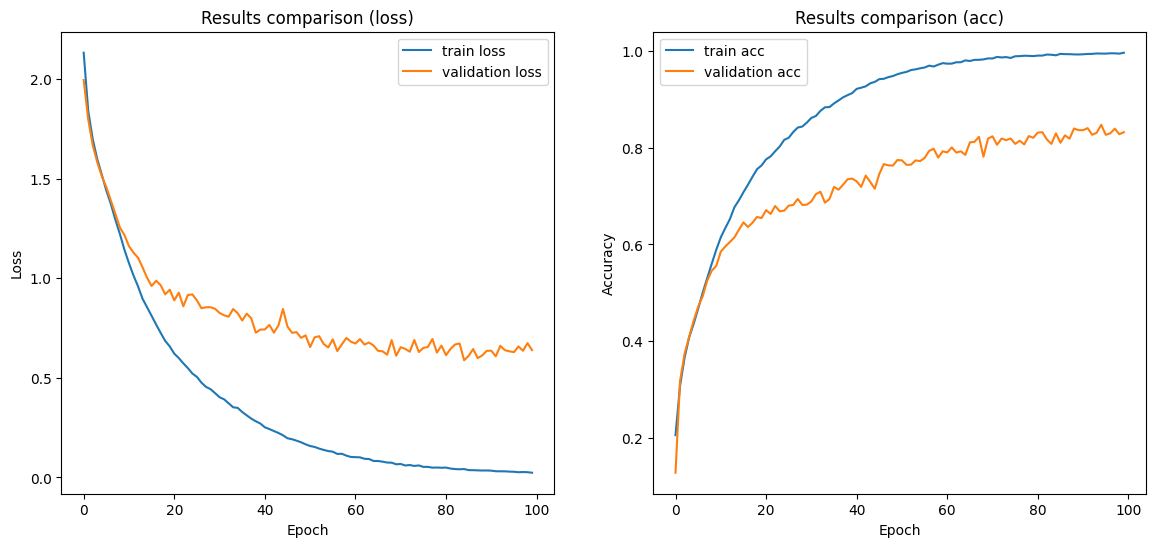

In [12]:
plt.figure(figsize=(14, 6)) 

plt.subplot(1, 2, 1) 
plt.plot(history_fractalnet.history['loss'][:100], label='train loss')
plt.plot(history_fractalnet.history['val_loss'][:100], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Results comparison (loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fractalnet.history['accuracy'][:100], label='train acc')
plt.plot(history_fractalnet.history['val_accuracy'][:100], label='validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Results comparison (acc)')
plt.legend()
plt.show()

In [13]:
predictions = fractal_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
accuracy_result = accuracy_score(y_test, predicted_labels)

print("Test samples accuracy:", accuracy_result)

83/83 [==============================] - 3s 22ms/step
Test samples accuracy: 0.9087121212121212


In [14]:
y_test_encoded = tf.keras.utils.to_categorical(y_test)
test_loss = fractal_model.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", test_loss)

Test loss: [0.4371477961540222, 0.9087121486663818]


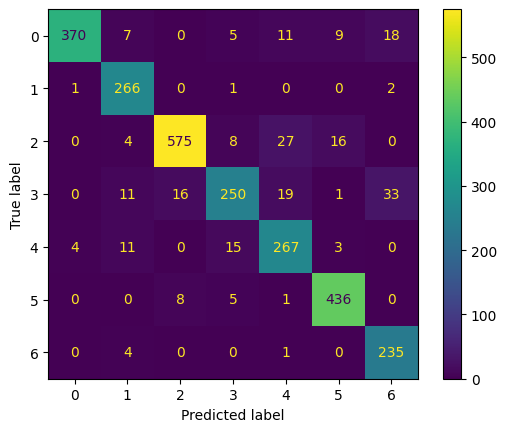

In [15]:
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, predicted_labels)
ConfusionMatrixDisplay(cm).plot()

In [16]:
classification_results = classification_report(y_test, predicted_labels, target_names=types)

print("Classification results:\n", classification_results)

Classification results:
                     precision    recall  f1-score   support

attack_helicopters       0.99      0.88      0.93       420
 fighter_aircrafts       0.88      0.99      0.93       270
             il-76       0.96      0.91      0.94       630
             tu-22       0.88      0.76      0.81       330
             tu-95       0.82      0.89      0.85       300
            tu-160       0.94      0.97      0.95       450
       noaircrafts       0.82      0.98      0.89       240

          accuracy                           0.91      2640
         macro avg       0.90      0.91      0.90      2640
      weighted avg       0.91      0.91      0.91      2640



In [ ]:
fractal_model.save('./fractalnet.h5')

In [ ]:
resnet_model = ResNet50(include_top=True,
                  weights=None,
                  input_shape=shape,
                  pooling='avg',
                  classes=len(types),
                  classifier_activation='softmax')

resnet_model.compile(keras.optimizers.RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

In [ ]:
history_resnet = resnet_model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_val, y_val_one_hot))

In [ ]:
vgg_model = VGG16(include_top=True,
                  weights=None,
                  input_shape=shape,
                  pooling='avg',
                  classes=len(types),
                  classifier_activation='softmax')
vgg_model.compile(keras.optimizers.RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

In [ ]:
history_vgg = vgg_model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_val, y_val_one_hot))

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_fractalnet.history['val_loss'][:100], label='fractalnet')
plt.plot(history_resnet.history['val_loss'], label='resnet')
plt.plot(history_vgg.history['val_loss'], label='vgg16')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Results comparison (loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fractalnet.history['val_accuracy'][:100], label='fractalnet')
plt.plot(history_resnet.history['val_accuracy'], label='resnet')
plt.plot(history_vgg.history['val_accuracy'], label='vgg16')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Results comparison (acc)')
plt.legend()
plt.show()